In [1]:
import os
import numpy as np
import nibabel as nib

import matplotlib.pyplot as plt

from skimage.color import gray2rgb

Давайте загрузим и посмотрим на данные пациентов

In [2]:
PATH2PATIENT = '../input/Train/Train/patient001/'

In [3]:
def visualize(image_data):
    '''
    Функция для послойной визуализации МРТ-изображения.
    image_data: 3-х мерный numpy массив
    '''
    
    slices = image_data.shape[-1]
    
    addition = int(slices % 3 != 0)

    fig, ax = plt.subplots(slices // 3 + addition, 3, figsize=(20,20), gridspec_kw={'wspace':0.1, 'hspace':0.1})
    for i in range(slices // 3 + addition):
        for j in range(3):
            ax[i, j].axis("off")
            
    for i in range(slices):
        ax[i // 3, i % 3].set_title("Slice number:{}".format(i))
        ax[i // 3, i % 3].imshow(image_data[:, :, i], cmap='gray')

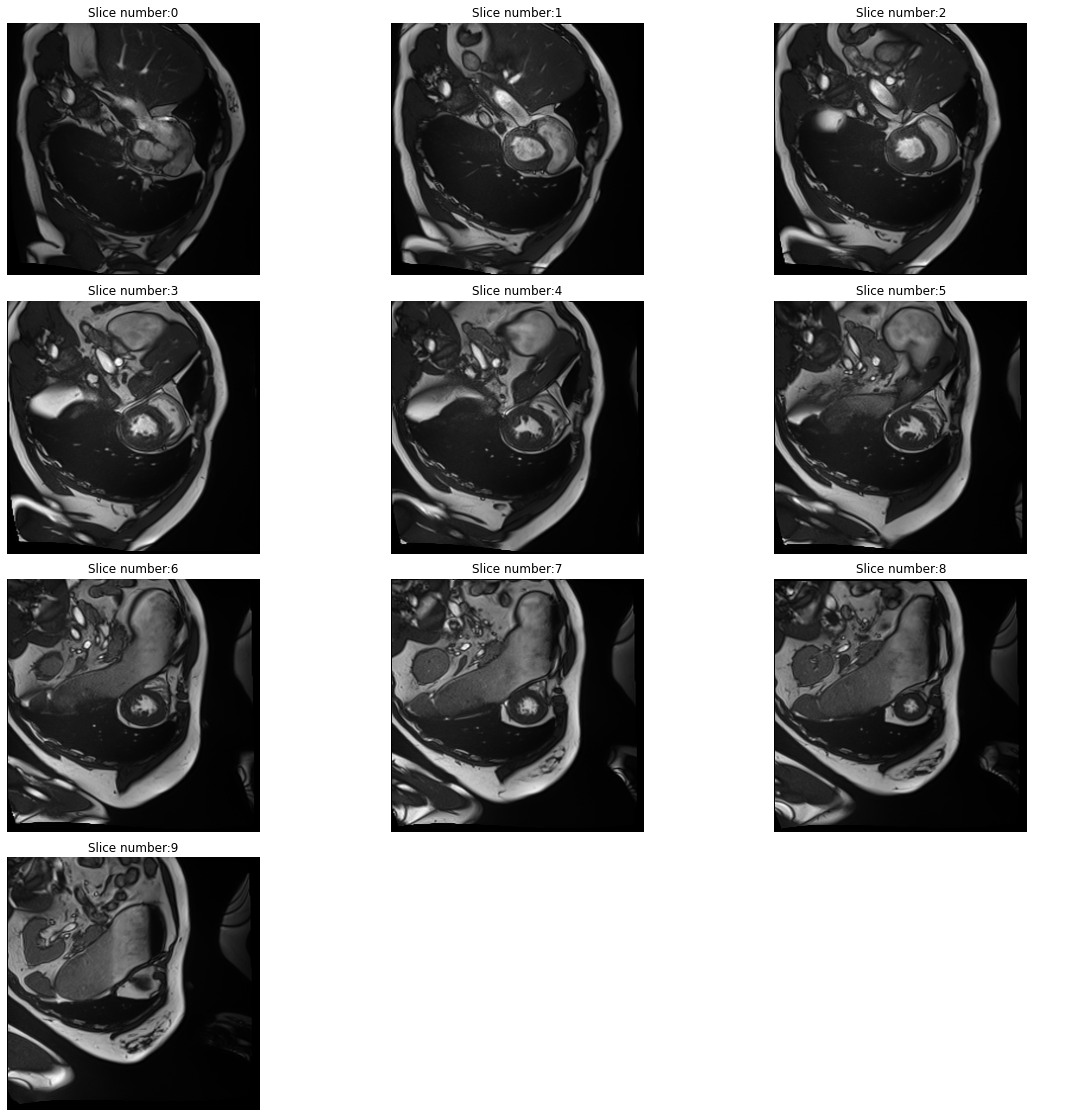

In [4]:
mri_image_path = os.path.join(PATH2PATIENT, 'patient001_frame01.nii')
# с помощью библиотеки nibabel загружаем МРТ-изображение
image = nib.load(mri_image_path)
# image - объект типа nibabel.Nifti1Image, 
# содержащий помимо самого изображения дополнителную мета информацию

image_data = image.get_fdata() 
# получаем непосредственно само изображение в градациях серого
# image_data - трёхмерный тензор   
# Визуализируем различные слои данного тензора по оси z
visualize(image_data)

Теперь попробуем посмотреть, каким анатомическим структурам соответствует экспертная разметка

In [5]:
def create_painted_areas(mri_image_slice, labels_slice):
    '''
    Функция "раскраски" анатомических структур
    '''
    
    painted_image = gray2rgb(mri_image_slice)

    for label_value in range(1, 4):
        mask = labels_slice == label_value
        painted_image[mask, label_value - 1] = 255
    
    return painted_image / (painted_image.max()+ 1e-5)
            
def visualize_with_labels(image_data, labels_data):
    
    assert image_data.shape == labels_data.shape, "Shapes should be equals!"
    
    slices = image_data.shape[-1]
    addition = int(slices % 3 != 0)
        
    fig, ax = plt.subplots(slices // 3 + addition , 3, figsize=(20,20), gridspec_kw={'wspace':0.1, 'hspace':0.1})
    for i in range(slices // 3 + addition):
        for j in range(3):
            ax[i, j].axis('off')
            
    for i in range(slices):
    
        ax[i // 3, i % 3].set_title("Slice number:{}".format(i))
        painted_image = create_painted_areas(image_data[..., i], labels_data[..., i])
        ax[i // 3, i % 3].imshow(painted_image)

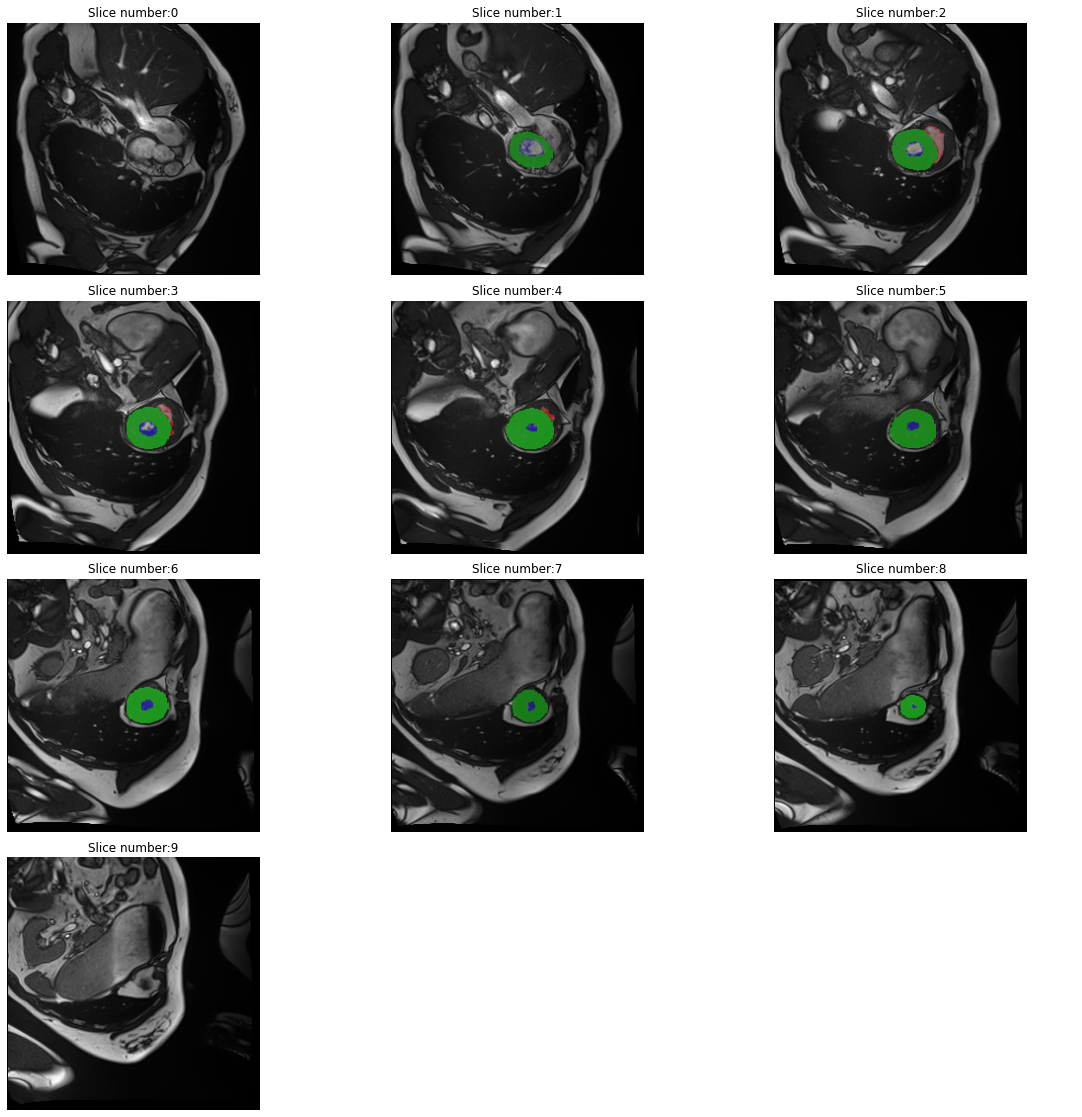

In [6]:
mri_image_path = os.path.join(PATH2PATIENT, 'patient001_frame12.nii')
labels_path = os.path.join(PATH2PATIENT, 'patient001_frame12_gt.nii')

mri_image = nib.load(mri_image_path).get_fdata()
labels = nib.load(labels_path).get_fdata()

visualize_with_labels(mri_image, labels)

Некоторые вспомогательные функции, которые, возможно, понадобятся Вам для обработки изображений

In [7]:

def read_info_file(path2file):
    '''
    Функция для обработки Info.cfg.
    Возвращает словарь c параметрами пациента
    '''

    patient_info = {}
    with open(path2file, 'r') as f:
        for line in f:
            param_name, value = line.split(':')
            param_name, value = param_name.rstrip().lstrip(), value.rstrip().lstrip()
            patient_info[param_name] = value

    return patient_info
    
def gt_to_one_hot(gt_image, unique=[0, 1, 2, 3]):
    '''
    Функция для кодирования изображения в 
    one hot представление (скорее всего, понадобится при обучении)
    На вход: разметка для некоторого слоя (height, width)
    На выходе: 3-x мерный тензор (height, width, classes)
    (для данной задачи classes = 4)
    '''
    
    one_hot_gt = np.zeros(gt_image.shape + (len(unique),), dtype = np.uint8)
    for i, label in enumerate(unique):
        one_hot_gt[..., i] = (gt_image == label).astype(np.float32)
    
    return one_hot_gt

In [8]:
def load_dataset(dataset_directory, cycle_type='ES', is_train = True):
    '''
    Загрузка датасета в RAM.
    Возвращает список из кортежей вида (3D МРТ-изображение, Разметка, Имя пациента)
    В случае загрузки данных из тестовой выборки (is_train == False), 
    поле разметки в кортеже имеет значение None
    '''
    assert cycle_type == 'ES' or cycle_type == 'ED'
    
    dataset = []
    for patient_name in os.listdir(dataset_directory):
        patient_path = os.path.join(dataset_directory,patient_name)
        info_file_path = os.path.join(patient_path, 'Info.cfg')
        
        patient_info = read_info_file(info_file_path)
        frame_number = patient_info[cycle_type]
        
        image_name = '{}_frame{}.nii'.format(patient_name, frame_number.zfill(2))
        image_data = nib.load(os.path.join(patient_path, image_name)).get_fdata()
        
        if is_train:
            gt_name = '{}_frame{}_gt.nii'.format(patient_name, frame_number.zfill(2))
            gt_data = nib.load(os.path.join(patient_path, gt_name)).get_fdata()
        else:
            gt_data = None
        
        dataset.append((image_data, gt_data, patient_name))
    
    return dataset

In [9]:
data_ES_train = load_dataset('../input/Train/Train/', 'ES', True)
data_ED_train = load_dataset('../input/Train/Train/', 'ED', True)
len(data_ES_train)

70

In [10]:
data_ES_test = load_dataset('../input/Test/Test/', 'ES', False)
data_ED_test = load_dataset('../input/Test/Test/', 'ED', False)
len(data_ES_test)

30

In [11]:
data_ES_test[0][0].shape

(256, 256, 11)

In [ ]:
train_ES_x = []
train_ES_y = []
train_ES_order = []
train_ES_names = []
for image in data_ES_train:
    #print (image[0].shape)
    for i in range(image[0].shape[2]):
        train_ES_x.append(image[0][...,i])
        train_ES_y.append(image[1][...,i])
        train_ES_order.append(i)
    train_ES_names.append(image[2])

In [ ]:
tmp_ES_x = train_ES_x


In [ ]:
train_ES_x = np.asarray(train_ES_x)
train_ES_x = np.expand_dims(train_ES_x, axis=3)

In [ ]:
train_ES_y = np.asarray(train_ES_y)
#train_ES_y = np.expand_dims(train_ES_y, axis=3)
train_ES_hot = []
for image in train_ES_y:
    train_ES_hot.append(gt_to_one_hot(image))
tmp_ES_hot = train_ES_hot
train_ES_hot = np.asarray(train_ES_hot)
train_ES_hot.shape

In [ ]:
print(train_ES_hot.shape)
print(train_ES_x.shape)

In [ ]:
train_ED_x = []
train_ED_y = []
train_ED_names = []
train_ED_order = []
for image in data_ED_train:
    #print (image[0].shape)
    for i in range(image[0].shape[2]):
        train_ED_x.append(image[0][...,i])
        train_ED_y.append(image[1][...,i])
        train_ED_order.append(i)
    train_ED_names.append(image[2])

In [ ]:
train_ED_y = np.asarray(train_ED_y)
tmp_ED_x = train_ED_x
train_ED_x = np.asarray(train_ED_x)
train_ED_x = np.expand_dims(train_ED_x, axis=3)
train_ED_hot = []
for image in train_ED_y:
    train_ED_hot.append(gt_to_one_hot(image))
tmp_ED_y = train_ED_hot
train_ED_hot = np.asarray(train_ED_hot)

In [ ]:
tmp_ED_hot = tmp_ED_y

In [ ]:
test_ES_x = []
#test_ES_y = []
test_ES_order = []
test_ES_names = []
for image in data_ES_test:
    #print (image[0].shape)
    for i in range(image[0].shape[2]):
        test_ES_x.append(image[0][...,i])
        #test_ES_y.append(image[1][...,i])
        test_ES_order.append(i)
        test_ES_names.append(image[2])

In [ ]:
test_ES_x = np.asarray(test_ES_x)
test_ES_x = np.expand_dims(test_ES_x, axis=3)

In [ ]:
test_ED_x = []
#test_ES_y = []
test_ED_order = []
test_ED_names = []
for image in data_ED_test:
    #print (image[0].shape)
    for i in range(image[0].shape[2]):
        test_ED_x.append(image[0][...,i])
        #test_ES_y.append(image[1][...,i])
        test_ED_order.append(i)
        test_ED_names.append(image[2])

In [ ]:
test_ED_x = np.asarray(test_ED_x)
test_ED_x = np.expand_dims(test_ED_x, axis=3)

In [ ]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    flipped_y_s = np.flip(keypoints, axis=2)
    return flipped_images, flipped_y_s

In [ ]:
to_append_ES_x, to_append_ES_y = left_right_flip(tmp_ES_x, tmp_ES_hot)
to_append_ED_x, to_append_ED_y = left_right_flip(tmp_ED_x, tmp_ED_hot)

In [ ]:
to_append_ES_x, to_append_ES_y = np.asarray(to_append_ES_x), np.asarray(to_append_ES_y)
to_append_ED_x, to_append_ED_y = np.asarray(to_append_ED_x), np.asarray(to_append_ED_y)


In [ ]:
to_append_ES_x = np.expand_dims(to_append_ES_x, axis=3)

In [ ]:
to_append_ED_x = np.expand_dims(to_append_ED_x, axis=3)

In [ ]:
train_ES_x = np.concatenate((train_ES_x, to_append_ES_x))
train_ED_x = np.concatenate((train_ED_x, to_append_ED_x))
train_ES_hot = np.concatenate((train_ES_hot, to_append_ES_y))
train_ED_hot = np.concatenate((train_ED_hot, to_append_ED_y))


In [ ]:
train_ES_x.shape

In [ ]:
rotation_angles = [7, 14]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12] 

In [ ]:
def alter_brightness(images, keypoints): 
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.8, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    altered_keypoint = []
    altered_keypoint.extend(keypoints)
    altered_keypoint.extend(keypoints)
    return altered_brightness_images, altered_keypoint

In [ ]:
to_append_ES_x, to_append_ES_y = alter_brightness(tmp_ES_x, tmp_ES_hot)
to_append_ED_x, to_append_ED_y = alter_brightness(tmp_ED_x, tmp_ED_hot)
to_append_ES_x, to_append_ES_y = np.asarray(to_append_ES_x), np.asarray(to_append_ES_y)
to_append_ED_x, to_append_ED_y = np.asarray(to_append_ED_x), np.asarray(to_append_ED_y)
to_append_ES_x = np.expand_dims(to_append_ES_x, axis=3)
to_append_ED_x = np.expand_dims(to_append_ED_x, axis=3)
train_ES_x = np.concatenate((train_ES_x, to_append_ES_x))
train_ED_x = np.concatenate((train_ED_x, to_append_ED_x))
train_ES_hot = np.concatenate((train_ES_hot, to_append_ES_y))
train_ED_hot = np.concatenate((train_ED_hot, to_append_ED_y))


In [ ]:
import tensorflow as tf

In [ ]:
img_height = 256
img_width = 256
num_channels = 1
img_shape = (img_height, img_width, num_channels)
n_classes = 4

In [ ]:
from tensorflow.keras.backend import concatenate

In [ ]:
#!pip install -U segmentation-models

In [ ]:
import segmentation_models as sm

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_ES_datagen = ImageDataGenerator(**data_gen_args)
mask_ES_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_ES_datagen.fit(train_ES_x, augment=True, seed=seed)
mask_ES_datagen.fit(train_ES_hot, augment=True, seed=seed)

image_ES_generator = image_ES_datagen.flow(
    train_ES_x,
    seed=seed)

mask_ES_generator = mask_ES_datagen.flow(
    train_ES_hot,
    seed=seed)

train_ES_generator = zip(image_ES_generator, mask_ES_generator)

In [ ]:
image_ED_datagen = ImageDataGenerator(**data_gen_args)
mask_ED_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_ED_datagen.fit(train_ED_x, augment=True, seed=seed)
mask_ED_datagen.fit(train_ED_hot, augment=True, seed=seed)

image_ED_generator = image_ED_datagen.flow(
    train_ED_x,
    seed=seed)

mask_ED_generator = mask_ED_datagen.flow(
    train_ED_hot,
    seed=seed)

train_ED_generator = zip(image_ED_generator, mask_ED_generator)

In [ ]:
model1 = sm.Unet('resnet101', classes=4, activation='softmax', input_shape=(256, 256, 1), encoder_weights=None)
model1.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
model2 = sm.Unet('resnet101', classes=4, activation='softmax', input_shape=(256, 256, 1), encoder_weights=None)
model2.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [ ]:
model1.fit(
   x=train_ES_x,
   y=train_ES_hot,
   batch_size=16,
   epochs=60,
   #validation_data=(x_val, y_val),
   validation_split = 0.1
)
model2.fit(
   x=train_ED_x,
   y=train_ED_hot,
   batch_size=16,
   epochs=60,
   #validation_data=(x_val, y_val),
   validation_split = 0.1
)

In [ ]:
preds_ES = model1.predict(test_ES_x)
preds_ED = model2.predict(test_ED_x)

In [ ]:
preds_ES.shape

In [ ]:
def prob_to_class(pred): #pred[0- ,]
    res = np.zeros((256, 256), dtype=int)
    for i in range(256):
        for j in range(256):
            ind = 0
            cur_prop = pred[i][j][0]
            for jj in range(1, 4):
                if pred[i][j][jj] > cur_prop:
                    cur_prop = pred[i][j][jj]
                    ind = jj
            res[i][j] = ind
    return res

In [ ]:
prob_to_class(preds_ES[0])

In [ ]:
labeled_ES = []
labeled_ES_names = []
cur_ES = []
for i in range(preds_ES.shape[0]):
    if i != 0:
        if test_ES_names[i] != test_ES_names[i - 1]:
            labeled_ES.append(np.asarray(cur_ES))
            labeled_ES_names.append(test_ES_names[i - 1])
            cur_ES = []
    cur_ES.append(prob_to_class(preds_ES[i]))

In [ ]:
if cur_ES != []:
    labeled_ES.append(np.asarray(cur_ES))
    labeled_ES_names.append(test_ES_names[preds_ES.shape[0] - 1])

In [ ]:
labeled_ES = np.asarray(labeled_ES)
labeled_ES.shape

In [ ]:
labeled_ES_names[0]

In [ ]:
labeled_ED = []
labeled_ED_names = []
cur_ED = []
for i in range(preds_ED.shape[0]):
    if i != 0:
        if test_ED_names[i] != test_ED_names[i - 1]:
            labeled_ED.append(np.asarray(cur_ED))
            labeled_ED_names.append(test_ED_names[i - 1])
            cur_ED = []
    cur_ED.append(prob_to_class(preds_ED[i]))

In [ ]:
if cur_ED != []:
    labeled_ED.append(np.asarray(cur_ED))
    labeled_ED_names.append(test_ED_names[preds_ED.shape[0] - 1])

In [ ]:
labeled_ED = np.asarray(labeled_ED)
labeled_ED[0].shape

In [ ]:
for i in range(len(labeled_ES)):
    for j in range(labeled_ES[i].shape[0]):
        if (not(np.all(labeled_ES[i][j] >= 0) and np.all(labeled_ES[i][j] < 4))):
            print("asd")

In [ ]:
print(labeled_ES[0].shape)

In [ ]:
labeled_ES_true = []
hel = np.zeros((1, 1))
for i in range(len(labeled_ES)):
    hel = np.zeros((256, 256, labeled_ES[i].shape[0]))
    for j in range(labeled_ES[i].shape[0]):
        hel[:,:,j] = labeled_ES[i][j]
    labeled_ES_true.append(hel)

In [ ]:
labeled_ES_true[0][3]

In [ ]:
labeled_ED_true = []
hel = np.zeros((1, 1))
for i in range(len(labeled_ED)):
    hel = np.zeros((256, 256, labeled_ED[i].shape[0]))
    for j in range(labeled_ED[i].shape[0]):
        hel[:,:,j] = labeled_ED[i][j]
    labeled_ED_true.append(hel)

In [ ]:
labeled_ES_true[0].shape

In [ ]:
labeled_ES_names == labeled_ED_names

In [ ]:
res = []
for i in range(len(labeled_ES_true)):
    res.append((labeled_ES_true[i].astype(int), labeled_ED_true[i].astype(int), labeled_ES_names[i]))
labeled_test_images = res

In [ ]:
np.all(res[0][0][:,:,0] >= 0) and np.all(res[0][0][:,:,0] < 4)

In [ ]:
for labeled_ES, labeled_ED, patient_name in labeled_test_images:
    if (not(np.all(labeled_ES[:,:,0] >= 0) and np.all(labeled_ES[:,:,0] < 4) and np.all(labeled_ED[:,:,0] >= 0) and
              np.all(labeled_ED[:,:,0] <4))):
        print(patient_name)

In [ ]:
for image_slice in range(volume.shape[-1]):
            for label in range(1, 4, 1):
                mask = (volume[..., image_slice] == label).astype(np.uint8)

In [ ]:
for image_slice in range(res[0][0].shape[-1]):
            for label in range(1, 4, 1):
                mask = (res[0][0][..., image_slice] == label).astype(np.uint8)
                print(mask)

In [ ]:
 with open('ss.csv', 'w') as f:
        f.write("ImageId, EncodedPixels\n")
        submission_writer._write_volume2file(f, res[0][0], res[0][2], 'ES')
        submission_writer._write_volume2file(f, res[0][1], res[0][2], 'ED')
        rle_encoded_mask = ' '.join([str(val) for val in submission_writer._rle_encoding(mask)])
        opened_file.write("{}_{}_{}_{},{}\n".format(patient_name, cycle_type, 
                                                  image_slice, label, rle_encoded_mask))

In [ ]:
class CSVWriter():
    '''
    Специальный класс для записи полученных разметок в csv файл
    в соответствии с требуемым форматом.
    Для записи полученных разметок необходимо сделать вызов метода write_to_csv,
    передав ему список из кортежей вида (labeled_ES, labeled_ED, patient_name),
    labeled_ES, labeled_ED - размеченные вашим алгоритмом изображения сердца 
    в моменты систолы и диастолы.
    labeled_ES и labeled_ED - numpy массивы с тремя измерениями 
    '''
    
    def __init__(self):
        pass
        
    
    def _rle_encoding(self, x):
        '''
        x: numpy array of shape (height, width), 1 - mask, 0 - background
        Returns run length as list
        '''
        dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1): run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths    
    
    
    def _write_volume2file(self, opened_file, volume, patient_name, cycle_type):
        
        for image_slice in range(volume.shape[-1]):
            for label in range(1, 4, 1):
                mask = (volume[..., image_slice] == label).astype(np.uint8)
                
                rle_encoded_mask = ' '.join([str(val) for val in self._rle_encoding(mask)])
                opened_file.write("{}_{}_{}_{},{}\n".format(patient_name, cycle_type, 
                                                          image_slice, label, rle_encoded_mask))
                
        
    def write_to_csv(self, labeled_dataset, filename='Submission.csv'):
        
        with open(filename, 'w') as f:
            f.write("ImageId,EncodedPixels\n")
            for labeled_ES1, labeled_ED1, patient_name in labeled_dataset:
                self._write_volume2file(f, labeled_ES1, patient_name, 'ES')
                self._write_volume2file(f, labeled_ED1, patient_name, 'ED')



In [ ]:
submission_writer = CSVWriter()
submission_writer.write_to_csv(labeled_test_images, 'MySubmission.csv')

Некоторые замечания:
<br>
<br>
1) Будьте внимательны, когда будете собирать размеченные вашим алгоритмом слои в 3-х мерные тензоры при записи в csv файл. Порядок должен быть таким же, как и в размечаемом вами МРТ-изображении.

2) Полученные разметки для каждого слоя должны иметь размер (256, 256).

3) Для получения лучшего качества обучения можно воспользоваться аугментацией имеющихся данных.

4) Зачастую NIfTI изображения удобно смотреть в специльных для этого программах  (https://www.facebase.org/help/viewing-nifti/ - ссылка откуда можно их скачать).
